## Set up

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path

if "workding_dir" not in globals():
    workding_dir = str(Path.cwd().parent)

os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

workding dir: /Users/inflaton/code/papers/maritime-incidents-ai-agents
loading env vars from: /Users/inflaton/code/papers/maritime-incidents-ai-agents/.env.example


True

In [3]:
%%time

from llm_toolkit.eval_openai import *
from tqdm.notebook import tqdm

tqdm.pandas()

data_path = os.getenv("DATA_PATH")
results_path = "results/openai_model_results_v3.csv"  # os.getenv("RESULTS_PATH")
num_ctx = os.getenv("NUM_CTX")
data_path, results_path, num_ctx

loading env vars from: /Users/inflaton/code/papers/maritime-incidents-ai-agents/.env.example
Adding /Users/inflaton/code/papers/maritime-incidents-ai-agents to sys.path
loading /Users/inflaton/code/papers/maritime-incidents-ai-agents/llm_toolkit/data_utils.py
CPU times: user 2.02 s, sys: 3.8 s, total: 5.82 s
Wall time: 3.41 s


('dataset/GMRID_v3.csv', 'results/openai_model_results_v3.csv', '8192')

In [4]:
# run cells above before running anything below

## Creating GMRID_v3.csv

In [4]:
import pandas as pd

df = pd.read_csv("dataset/cleaned_data.csv")
df.shape

(5780, 17)

In [5]:
df.drop_duplicates(subset=["Details"], inplace=True, keep="first")
df.shape

(5750, 17)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5750 entries, 0 to 5779
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  5750 non-null   int64  
 1   Headline            5750 non-null   object 
 2   Details             5750 non-null   object 
 3   Severity            5750 non-null   object 
 4   Category            5750 non-null   object 
 5   Region              5750 non-null   object 
 6   Datetime            5750 non-null   object 
 7   Year                5750 non-null   int64  
 8   lat                 3861 non-null   float64
 9   lon                 3861 non-null   float64
 10  maritime_label      5750 non-null   bool   
 11  found_ports         5748 non-null   object 
 12  contains_port_info  5748 non-null   float64
 13  if_labeled          5748 non-null   object 
 14  Month               5748 non-null   float64
 15  Week                5748 non-null   float64
 16  Headline_De

In [7]:
# convert Headline, Details to string
df["Headline"] = df["Headline"].astype(str)
df["Details"] = df["Details"].astype(str)

# convert Datetime to datetime
df["Datetime"] = pd.to_datetime(df["Datetime"])

# convert maritime_label, if_labeled to bool
df["maritime_label"] = df["maritime_label"].astype(bool)
df["contains_port_info"] = df["contains_port_info"].astype(bool)

# convert found_ports to list
df["found_ports"] = df["found_ports"].apply(
    lambda x: eval(x) if isinstance(x, str) else []
)

# convert id to int
df["id"] = df["id"].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5750 entries, 0 to 5779
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  5750 non-null   int64         
 1   Headline            5750 non-null   object        
 2   Details             5750 non-null   object        
 3   Severity            5750 non-null   object        
 4   Category            5750 non-null   object        
 5   Region              5750 non-null   object        
 6   Datetime            5750 non-null   datetime64[ns]
 7   Year                5750 non-null   int64         
 8   lat                 3861 non-null   float64       
 9   lon                 3861 non-null   float64       
 10  maritime_label      5750 non-null   bool          
 11  found_ports         5750 non-null   object        
 12  contains_port_info  5750 non-null   bool          
 13  if_labeled          5748 non-null   object        
 1

/var/folders/7x/56svhln929zdh2xhr3mwqg4r0000gn/T/ipykernel_70203/1689747020.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Datetime"] = pd.to_datetime(df["Datetime"])


In [8]:
# find rows with datatime does not match the Year and Month
df["year"] = df["Datetime"].dt.year.astype("int64")
df["month"] = df["Datetime"].dt.month.astype("int64")
df["week"] = df["Datetime"].dt.isocalendar().week.astype("int64")

In [9]:
df["Year"].info()

<class 'pandas.core.series.Series'>
Index: 5750 entries, 0 to 5779
Series name: Year
Non-Null Count  Dtype
--------------  -----
5750 non-null   int64
dtypes: int64(1)
memory usage: 89.8 KB


In [10]:
df["Month"].info()

<class 'pandas.core.series.Series'>
Index: 5750 entries, 0 to 5779
Series name: Month
Non-Null Count  Dtype  
--------------  -----  
5748 non-null   float64
dtypes: float64(1)
memory usage: 89.8 KB


In [11]:
df["Week"].info()

<class 'pandas.core.series.Series'>
Index: 5750 entries, 0 to 5779
Series name: Week
Non-Null Count  Dtype  
--------------  -----  
5748 non-null   float64
dtypes: float64(1)
memory usage: 89.8 KB


In [12]:
df["Year"].equals(df["year"]), df["Month"].equals(df["month"])

(True, False)

In [13]:
df[df["Year"] != df["year"]]

,id,Headline,Details,Severity,Category,Region,Datetime,Year,lat,lon,maritime_label,found_ports,contains_port_info,if_labeled,Month,Week,Headline_Details,year,month,week


In [14]:
df[df["Week"] != df["week"]]

,id,Headline,Details,Severity,Category,Region,Datetime,Year,lat,lon,maritime_label,found_ports,contains_port_info,if_labeled,Month,Week,Headline_Details,year,month,week
5078,5079,Daily COVID-19 roundup: Serum Institute sets p...,IHS Markit perspectiveImplicationsBahrain has ...,Minor,Regulatory Advisory,Bahrain,2020-07-12 14:44:00,2020,26.06670,50.55770,False,[],True,NaN,NaN,NaN,NaN,2020,7,28
5079,5080,Daily COVID-19 roundup: US’s COVAXX enters USD...,IHS Markit perspectiveImplicationsThe number o...,Minor,Regulatory Advisory,Argentina,2020-11-26 14:03:00,2020,52.13263,5.29127,False,[],True,NaN,NaN,NaN,NaN,2020,11,48


In [15]:
df[df["Month"] != df["month"]]

,id,Headline,Details,Severity,Category,Region,Datetime,Year,lat,lon,maritime_label,found_ports,contains_port_info,if_labeled,Month,Week,Headline_Details,year,month,week
5078,5079,Daily COVID-19 roundup: Serum Institute sets p...,IHS Markit perspectiveImplicationsBahrain has ...,Minor,Regulatory Advisory,Bahrain,2020-07-12 14:44:00,2020,26.06670,50.55770,False,[],True,NaN,NaN,NaN,NaN,2020,7,28
5079,5080,Daily COVID-19 roundup: US’s COVAXX enters USD...,IHS Markit perspectiveImplicationsThe number o...,Minor,Regulatory Advisory,Argentina,2020-11-26 14:03:00,2020,52.13263,5.29127,False,[],True,NaN,NaN,NaN,NaN,2020,11,48


In [16]:
print_row_details(df, [5053])

--------------------------------------------------
id: 5079
--------------------------------------------------
Headline: Daily COVID-19 roundup: Serum Institute sets price for Oxford COVID-19 vaccine at USD8 for private market, Bahrain grants regulatory approval to Pfizer’s COVID-19 vaccine
--------------------------------------------------
Details: IHS Markit perspectiveImplicationsBahrain has become the second country after the UK to grant emergency use authorisation for Pfizer (US) and BioNTech (Germany)’s coronavirus disease 2019 (COVID-19) vaccine. Pfizer also became the first pharmaceutical firm to seek emergency approval of a COVID-19 vaccine by the Drugs Controller General of India (DCGI); this was quickly followed by the Serum Institute of India (SII) that has also filed for emergency use authorisation in India of its domestically produced version of AstraZeneca (UK) and Oxford University’s COVID-19 vaccine, Covishield. World Health Organization (WHO) representatives have conf

In [17]:
df_v2 = pd.read_csv("dataset/global_incidents_v2.csv")
df_v2.shape

(5744, 4)

In [18]:
df_v2.drop_duplicates(subset=["Details"], inplace=True)
df_v2.shape

(5744, 4)

In [19]:
df_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5744 entries, 0 to 5743
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Details           5744 non-null   object
 1   Details_cleaned   5744 non-null   object
 2   Category          5744 non-null   object
 3   Summarized_label  5744 non-null   object
dtypes: object(4)
memory usage: 179.6+ KB


In [20]:
# Combine DataFrames on 'Details'
combined_df = pd.merge(df, df_v2, on="Details", how="inner")

# Display the combined DataFrame
combined_df.shape

(5744, 23)

In [21]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5744 entries, 0 to 5743
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  5744 non-null   int64         
 1   Headline            5744 non-null   object        
 2   Details             5744 non-null   object        
 3   Severity            5744 non-null   object        
 4   Category_x          5744 non-null   object        
 5   Region              5744 non-null   object        
 6   Datetime            5744 non-null   datetime64[ns]
 7   Year                5744 non-null   int64         
 8   lat                 3856 non-null   float64       
 9   lon                 3856 non-null   float64       
 10  maritime_label      5744 non-null   bool          
 11  found_ports         5744 non-null   object        
 12  contains_port_info  5744 non-null   bool          
 13  if_labeled          5742 non-null   object      

In [22]:
combined_df["week"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 5744 entries, 0 to 5743
Series name: week
Non-Null Count  Dtype
--------------  -----
5744 non-null   int64
dtypes: int64(1)
memory usage: 45.0 KB


In [23]:
combined_df.drop(columns=["Category_x", "Year", "Month", "Week"], inplace=True)
combined_df.rename(
    columns={
        "Category_y": "Category",
        "year": "Year",
        "month": "Month",
        "week": "Week",
    },
    inplace=True,
)

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5744 entries, 0 to 5743
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  5744 non-null   int64         
 1   Headline            5744 non-null   object        
 2   Details             5744 non-null   object        
 3   Severity            5744 non-null   object        
 4   Region              5744 non-null   object        
 5   Datetime            5744 non-null   datetime64[ns]
 6   lat                 3856 non-null   float64       
 7   lon                 3856 non-null   float64       
 8   maritime_label      5744 non-null   bool          
 9   found_ports         5744 non-null   object        
 10  contains_port_info  5744 non-null   bool          
 11  if_labeled          5742 non-null   object        
 12  Headline_Details    5742 non-null   object        
 13  Year                5744 non-null   int64       

In [24]:
combined_df.to_csv(data_path, index=False)

In [25]:
df_v3 = combined_df
df_v3

,id,Headline,Details,Severity,Region,Datetime,lat,lon,maritime_label,found_ports,contains_port_info,if_labeled,Headline_Details,Year,Month,Week,Details_cleaned,Category,Summarized_label
0,1,Grasberg Mine- Grasberg mine workers extend st...,Media sources indicate that workers at the Gra...,Moderate,Indonesia,2017-05-28 17:08:00,-4.05608,137.11302,False,[freeport],True,False,Grasberg Mine- Grasberg mine workers extend st...,2017,5,21,medium source indicate worker grasberg mine ex...,Mine Workers Strike,Worker Strike
1,2,Indonesia: Undersea internet cables damaged by...,News sources are stating that recent typhoons ...,Minor,Indonesia,2017-04-09 14:30:00,NaN,NaN,False,[hong kong],True,False,Indonesia: Undersea internet cables damaged by...,2017,4,14,news source stating recent typhoon impact hong...,Travel Warning,Weather
2,3,Shanghai port congestion impacts terminals in ...,The persisting port congestion at Shanghai’s Y...,Minor,China,2017-04-27 09:16:00,29.52000,121.33190,True,"[ningbo, qingdao, shanghai]",True,False,Shanghai port congestion impacts terminals in ...,2017,4,17,persisting port congestion shanghai ’ yangshan...,Port Congestion,Administrative Issue
3,4,UPDATE - Indonesia: Explosion at KP Terminal i...,Updated local media sources from Jakarta indic...,Extreme,Indonesia,2017-05-24 15:15:00,-6.22465,106.86700,True,[jakarta],True,False,UPDATE - Indonesia: Explosion at KP Terminal i...,2017,5,21,updated local medium source jakarta indicate e...,"Bombing, Police Operations",Terrorism
4,5,UPDATE - Indonesia: Police confirm two explosi...,"According to local police in Jakarta, two expl...",Extreme,Indonesia,2017-05-24 16:20:00,NaN,NaN,True,[jakarta],True,True,UPDATE - Indonesia: Police confirm two explosi...,2017,5,21,according local police jakarta two explosion c...,"Bombing, Police Operations",Terrorism
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5739,5776,Winter storm may bring inclement weather condi...,Intelligence received by Everstream Analytics ...,Moderate,United States,2020-12-16 02:47:00,38.90072,-77.05440,False,[new york],True,False,Winter storm may bring inclement weather condi...,2020,12,51,intelligence received everstream analytics ind...,Ice Storm,Weather
5740,5777,Winter weather expected to continue to impact ...,Meteorological sources indicate that a series ...,Minor,United States,2020-12-31 18:15:00,41.30357,-72.90561,False,"[new york, virginia]",True,True,Winter weather expected to continue to impact ...,2020,12,53,meteorological source indicate series winter s...,"Roadway Closure / Disruption, Ground Transport...",Weather
5741,5778,Workers of Svitzer Australia plan to strike on...,Industry sources report on December 7 that Svi...,Moderate,Australia,2020-07-12 06:16:00,-38.35169,145.25050,False,"[geelong, melbourne]",True,False,Workers of Svitzer Australia plan to strike on...,2020,7,28,industry source report december 7 svitzer aust...,Industrial Action,Worker Strike
5742,5779,Workers stage 24-hour stoppage at DP World Ter...,Industry sources indicate on December 14 that ...,Moderate,Australia,2020-12-14 16:52:00,NaN,NaN,True,[fremantle],True,True,Workers stage 24-hour stoppage at DP World Ter...,2020,12,51,industry source indicate december 14 worker dp...,Port Strike,Worker Strike


In [26]:
df_v2.columns

Index(['Details', 'Details_cleaned', 'Category', 'Summarized_label'], dtype='object')

In [27]:
df_v3[df_v2.columns].equals(df_v2)

True

In [28]:
for col in df_v3.columns:
    nan_count = df_v3[col].isna().sum()
    if nan_count > 0:
        print(f"{col}: {nan_count}")

lat: 1888
lon: 1888
if_labeled: 2
Headline_Details: 2


In [29]:
df_v3[
    [
        "Headline",
        "contains_port_info",
        "lat",
        "lon",
        "found_ports",
        "Region",
        "Datetime",
        "Summarized_label",
    ]
]

,Headline,contains_port_info,lat,lon,found_ports,Region,Datetime,Summarized_label
0,Grasberg Mine- Grasberg mine workers extend st...,True,-4.05608,137.11302,[freeport],Indonesia,2017-05-28 17:08:00,Worker Strike
1,Indonesia: Undersea internet cables damaged by...,True,NaN,NaN,[hong kong],Indonesia,2017-04-09 14:30:00,Weather
2,Shanghai port congestion impacts terminals in ...,True,29.52000,121.33190,"[ningbo, qingdao, shanghai]",China,2017-04-27 09:16:00,Administrative Issue
3,UPDATE - Indonesia: Explosion at KP Terminal i...,True,-6.22465,106.86700,[jakarta],Indonesia,2017-05-24 15:15:00,Terrorism
4,UPDATE - Indonesia: Police confirm two explosi...,True,NaN,NaN,[jakarta],Indonesia,2017-05-24 16:20:00,Terrorism
...,...,...,...,...,...,...,...,...
5739,Winter storm may bring inclement weather condi...,True,38.90072,-77.05440,[new york],United States,2020-12-16 02:47:00,Weather
5740,Winter weather expected to continue to impact ...,True,41.30357,-72.90561,"[new york, virginia]",United States,2020-12-31 18:15:00,Weather
5741,Workers of Svitzer Australia plan to strike on...,True,-38.35169,145.25050,"[geelong, melbourne]",Australia,2020-07-12 06:16:00,Worker Strike
5742,Workers stage 24-hour stoppage at DP World Ter...,True,NaN,NaN,[fremantle],Australia,2020-12-14 16:52:00,Worker Strike


In [30]:
v2_dfs = {}
for type in ["train", "test"]:
    df_v2_test = pd.read_csv(f"dataset/global_incidents_v2-{type}.csv")
    v2_dfs[type] = df_v2_test

    combined_df = pd.merge(df_v2_test, df_v3, on="Details", how="inner")
    combined_df.rename(
        columns={
            "Category_y": "Category",
            "Details_cleaned_y": "Details_cleaned",
            "Summarized_label_y": "Summarized_label",
        },
        inplace=True,
    )
    df_v3_test = combined_df[df_v3.columns]
    df_v3_test.to_csv(data_path.replace(".csv", f"-{type}.csv"), index=False)

In [31]:
df_v3_test = pd.read_csv(data_path.replace(".csv", "-test.csv"))
df_v3_test[v2_dfs["test"].columns].equals(v2_dfs["test"])

True

In [32]:
df_v3_train = pd.read_csv(data_path.replace(".csv", "-train.csv"))
df_v3_train[v2_dfs["train"].columns].equals(v2_dfs["train"])

False

In [33]:
df_v3_train.shape, df_v3_test.shape

((4594, 19), (1147, 19))

In [34]:
v2_dfs["train"].shape, v2_dfs["test"].shape

((4597, 4), (1147, 4))

In [35]:
v2_dfs["train"][~v2_dfs["train"].Details.isin(df_v3_train.Details)]

,Details,Details_cleaned,Category,Summarized_label
465,Local media sources indicate on September 13 t...,local medium source indicate september 13 hurr...,Weather Advisory,Weather
1277,"In the Yellow Sea, north of the island of Taiw...",yellow sea north island taiwan people 's liber...,"Miscellaneous Events, Political Info / Event, ...",Human Error
1669,Shipping sources on April 25 indicate that adv...,shipping source april 25 indicate adverse weat...,Port Congestion,Weather


In [36]:
v2_dfs["train"][~v2_dfs["train"].Details.isin(df_v2.Details)]

,Details,Details_cleaned,Category,Summarized_label
465,Local media sources indicate on September 13 t...,local medium source indicate september 13 hurr...,Weather Advisory,Weather
1277,"In the Yellow Sea, north of the island of Taiw...",yellow sea north island taiwan people 's liber...,"Miscellaneous Events, Political Info / Event, ...",Human Error
1669,Shipping sources on April 25 indicate that adv...,shipping source april 25 indicate adverse weat...,Port Congestion,Weather


In [37]:
# find id in [465, 1277, 1669]
df_v3_train[df_v3_train.id.isin([465, 1277, 1669])]

,id,Headline,Details,Severity,Region,Datetime,lat,lon,maritime_label,found_ports,contains_port_info,if_labeled,Headline_Details,Year,Month,Week,Details_cleaned,Category,Summarized_label


In [38]:
# find id in [465, 1277, 1669]
df_v3[df_v3.id.isin([465, 1277, 1669])]

,id,Headline,Details,Severity,Region,Datetime,lat,lon,maritime_label,found_ports,contains_port_info,if_labeled,Headline_Details,Year,Month,Week,Details_cleaned,Category,Summarized_label
462,465,Police Presence Bolstered in Zhuhai ahead of I...,"On Monday, media sources reported that police ...",Minor,China,2018-10-22 23:44:00,22.27073,113.57668,False,"[hong kong, macau, zhuhai]",True,False,Police Presence Bolstered in Zhuhai ahead of I...,2018,10,43,monday medium source reported police begun dep...,Miscellaneous Events,Administrative Issue
1267,1277,Canada: Snowfall warning in effect for Vancouv...,Environment Canada currently has a snowfall wa...,Minor,Canada,2019-02-22 15:40:00,49.28674,-123.13742,False,[vancouver],True,True,Canada: Snowfall warning in effect for Vancouv...,2019,2,8,environment canada currently snowfall warning ...,"Ground Transportation Advisory, Weather Advisory",Weather
1657,1669,Hydrofluoric acid leak triggers hazmat respons...,Updated sources indicate that the hydrofluoric...,Moderate,Australia,2019-08-05 15:02:00,-37.83597,144.79576,True,[victoria],True,True,Hydrofluoric acid leak triggers hazmat respons...,2019,8,32,updated source indicate hydrofluoric acid leak...,Hazmat Response,Accident


In [39]:
# drop id in [465, 1277, 1669]
df_v3.drop(df_v3[df_v3.id.isin([465, 1277, 1669])].index, inplace=True)

In [40]:
# find id in [465, 1277, 1669]
df_v3[df_v3.id.isin([465, 1277, 1669])]

,id,Headline,Details,Severity,Region,Datetime,lat,lon,maritime_label,found_ports,contains_port_info,if_labeled,Headline_Details,Year,Month,Week,Details_cleaned,Category,Summarized_label


In [41]:
df_v3.to_csv(data_path, index=False)

In [42]:
df_v3 = pd.read_csv(data_path)
df_v3.shape

(5741, 19)

In [43]:
df_v3_train.shape, df_v3_test.shape

((4594, 19), (1147, 19))

In [44]:
df_v3_train.shape[0] / df_v3_test.shape[0]

4.005231037489102

In [45]:
df_v3_train[v2_dfs["train"].columns][:465].equals(v2_dfs["train"][:465])

True

In [46]:
df_v3_train[v2_dfs["train"].columns][:466].equals(v2_dfs["train"][:466])

False

In [47]:
df_v3_test[v2_dfs["test"].columns].equals(v2_dfs["test"])

True

## Debug Few-shot Prompting for JSON Outputs

In [7]:
%%time

from llm_toolkit.eval_openai import *

evaluate_model_with_num_shots(
    "gpt-4o-mini",
    data_path,
    results_path=results_path,
    range_num_shots=[10],
    max_entries=1,
    debug=True,
)

Evaluating model: gpt-4o-mini
loading train/test data files
--- evaluating 1 entries
DatasetDict({
    train: Dataset({
        features: ['id', 'Headline', 'Details', 'Severity', 'Region', 'Datetime', 'lat', 'lon', 'maritime_label', 'found_ports', 'contains_port_info', 'if_labeled', 'Headline_Details', 'Year', 'Month', 'Week', 'Details_cleaned', 'Category', 'Summarized_label'],
        num_rows: 4594
    })
    test: Dataset({
        features: ['id', 'Headline', 'Details', 'Severity', 'Region', 'Datetime', 'lat', 'lon', 'maritime_label', 'found_ports', 'contains_port_info', 'if_labeled', 'Headline_Details', 'Year', 'Month', 'Week', 'Details_cleaned', 'Category', 'Summarized_label'],
        num_rows: 1
    })
})
* Evaluating with num_shots: 10
Generating prompt templates for 10 shots with Headline_Details and Summarized_label


  0%|          | 0/1 [00:00<?, ?it/s]

Setting debug mode to: True
[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "input": "Courts, schools and hospitals evacuated across Saint Petersberg due to anonymous threats Russian media sources are reporting that courts, schools, and hospitals across Saint Petersberg have been evacuated today due to anonymous threats. It is understood that people have been evacuated from Petrodvorets, Oktyabrsky, Kolpinsky, Petrogradsky, Kuibyshevsky and Sestroretsky district courts. Furthermore, the State University of the Sea and River Fleet, St. Petersburg State University of Railway Engineering, Higher School of Folk Arts, St. Petersburg State University of Telecommunications, and S.M. Military Medical Academy Kirov have all been evacuated. This is the fourth consecutive week of evacuations from public buildings due to such threats. It is not known when the situation will normalise."
}
[chain/start] [chain:RunnableSequence > prompt:ChatPromptTemplate] Entering Prompt ru

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

[llm/end] [chain:RunnableSequence > llm:ChatOpenAI] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "{\n  \"category\": \"Terrorism\",\n  \"specific_tags\": [\"Bomb Threat\", \"Public Safety\"]\n}",
        "generation_info": {
          "finish_reason": "stop",
          "logprobs": null
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "{\n  \"category\": \"Terrorism\",\n  \"specific_tags\": [\"Bomb Threat\", \"Public Safety\"]\n}",
            "additional_kwargs": {
              "refusal": null
            },
            "response_metadata": {
              "token_usage": {
                "completion_tokens": 24,
                "prompt_tokens": 2027,
                "total_tokens": 2051,
                "comple

In [9]:
prompt = "System: Task: Classify Inputs into Predefined Categories\n\nYour primary objective is to analyze the given input and assign it to one of the predefined categories: ['Weather', 'Worker Strike', 'Administrative Issue', 'Human Error', 'Cyber Attack', 'Terrorism', 'Accident', 'Others']. Evaluate the content carefully and use the defining characteristics of each category to ensure an accurate classification.\n\nGuidelines:\n1. Understand the Categories:\nEach category has specific attributes that distinguish it. Familiarize yourself with these attributes by referring to the category descriptions provided in the JSON below. Use these details to guide your classification:\n\n{'Weather': ['Flooding', 'Severe Winds', 'Weather Advisory', 'Tropical Cyclone', 'Storm', 'Ice Storm', 'Earthquake', 'Tornado', 'Typhoon', 'Landslide', 'Water', 'Hurricane', 'Wildfire', 'Blizzard', 'Hail'], 'Worker Strike': ['Mine Workers Strike', 'Production Halt', 'Protest', 'Riot', 'Port Strike', 'General Strike', 'Civil Service Strike', 'Civil Unrest Advisory', 'Cargo Transportation Strike', 'Energy Sector Strike'], 'Administrative Issue': ['Port Congestion', 'Police Operations', 'Roadway Closure', 'Disruption', 'Cargo', 'Industrial Action', 'Port Disruption', 'Cargo Disruption', 'Power Outage', 'Port Closure', 'Maritime Advisory', 'Train Delays', 'Ground Transportation Advisory', 'Public Transportation Disruption', 'Trade Regulation', 'Customs Regulation', 'Regulatory Advisory', 'Industry Directives', 'Security Advisory', 'Public Holidays', 'Customs Delay', 'Public Health Advisory', 'Detention', 'Aviation Advisory', 'Waterway Closure', 'Plant Closure', 'Border Closure', 'Delay', 'Industrial zone shutdown', 'Trade Restrictions', 'Closure', 'Truck Driving Ban', 'Insolvency', 'Environmental Regulations', 'Postal Disruption', 'Travel Warning'], 'Human Error': ['Workplace Accident', 'Individuals in Focus', 'Military Operations', 'Flight Delays', 'Cancellations', 'Political Info', 'Political Event'], 'Cyber Attack': ['Network Disruption', 'Ransomware', 'Data breach', 'Phishing'], 'Terrorism': ['Bombing', 'Warehouse Theft', 'Public Safety', 'Security', 'Organized Crime', 'Piracy', 'Kidnap', 'Shooting', 'Robbery', 'Cargo theft', 'Bomb Detonation', 'Terror Attack', 'Outbreak Of War', 'Militant Action'], 'Accident': ['Hazmat Response', 'Maritime Accident', 'Vehicle Accident', 'Death', 'Injury', 'Non-industrial Fire', 'Chemical Spill', 'Industrial Fire', 'Fuel Disruption', 'Airline Incident', 'Crash', 'Explosion', 'Train Accident', 'Derailment', 'Sewage Disruption', 'Barge Accident', 'Bridge Collapse', 'Structure Collapse', 'Airport Accident', 'Force Majeure', 'Telecom Outage'], 'Others': ['Miscellaneous Events', 'Miscellaneous Strikes', 'Outbreak of disease']}\n\n2. Contextual Analysis:\nConsider the broader context of the input. If an input could potentially fit into multiple categories, select the one that most closely aligns with its primary intent or focus.\n3. Handling Ambiguity:\nFor ambiguous inputs or those that do not clearly align with any category, choose the category that most closely matches the content provided.\n4. Ensure Accuracy and Consistency:\nStrive for consistent and accurate classifications. Avoid arbitrary or random assignments.\n5. Provide Feedback:\nIf the input cannot be classified into any of the given categories, classify it as “Others.”\n\nInstructions for Output:\n1. Once the category is identified, provide “specific tags” by selecting from the list corresponding to the identified category, as defined in the JSON.\n2. Ensure the selected “specific tags” accurately reflect the details and context of the input.\n\nOutput Format:\n\nReturn your classification in the following JSON format:\n\n{\n  \"category\": \"<Selected Category>\",\n  \"specific_tags\": [\"<Selected Tag 1>\", \"<Selected Tag 2>\", ...]\n}\n\n\n\nExample Inputs and Outputs:\n\n- Input:\n\nLocal sources reported that operations at Pier 1 and 2 container terminals at the Port of Durban have suspended due to strong winds on December 27 from 18:50 (local time) and resumed at 23:10 on the same day. For Pier 2 terminal, operations stopped at 19:30 and resumed at 20:35 respectively.\n\n- Output:\n\n{\n  \"category\": \"Weather\",\n  \"specific_tags\": [\"Severe Winds\"]\n}\n\n- Input:\n\nInformation received states that emergency personnel are working to contain a blaze at Off Road Warehouse in commercial San Diego, on 17 November. It is detailed that the store is located at 7915 Balboa Avenue. Traffic maps show that Balboa Avenue is closed both ways between Mercury Street and Convoy Street. Travelers should use caution in the area and divert away from any encountered fire suppression operations.\n\n- Output:\n\n{\n  \"category\": \"Administrative Issue\",\n  \"specific_tags\": [\"Roadway Closure\", \"Public Safety Advisory\"]\n}\n\n- Input:\n\nProtests against climate change are anticipated nationwide on 29 November and 6 December as part of the ‘Fridays for Future’ global climate strike. Specific details of planned events have not been confirmed, but are likely to occur in major cities across the country. Previous climate strikes have seen large turnout in cities such as New York City, Philadelphia, and Washington, D.C.\n\n- Output:\n\n{\n  \"category\": \"Worker Strike\",\n  \"specific_tags\": [\"Protest\", \"Civil Unrest Advisory\"]\n}\n\n- Input:\n\nGovernment sources reported a fire at the Woolwich Dockyard, located near Belson Rd and Borgard Rd. No injuries were immediately reported. All rail lines from London towards Slade Green are running again. This incident is closed.\n\n- Output:\n\n{\n  \"category\": \"Accident\",\n  \"specific_tags\": [\"Non-industrial Fire\"]\n}\n\n- Input:\n\nLocal media sources indicated on November 30 that the Ekurhuleni Central Crime Intelligence Unit arrested 4 suspects and recovered computer printer equipment cargo from their November 21 truck theft at the corner of Main Reef Road and Ulysses Street in Cleveland. The truck was en route from Durban to Johannesburg when it was hijacked in Randfontein. The cargo was worth ZAR 5 million (EUR 309018.21; USD 352673.95), and some laptops are still missing. Distributors should be mindful of cargo theft risks in Randfontein and should plan accordingly.\n\n- Output:\n\n{\n  \"category\": \"Terrorism\",\n  \"specific_tags\": [\"Cargo Theft\", \"Organized Crime\"]\n}\n\n- Input:\n\nAnonymous sources have reported that a ransomware attack has disrupted network operations for a major logistics provider. The attack occurred on November 15, and data breaches were confirmed, exposing sensitive customer and shipment details. The company has stated that recovery is underway but advised customers to expect delays.\n\n- Output:\n\n{\n  \"category\": \"Cyber Attack\",\n  \"specific_tags\": [\"Ransomware\", \"Data Breach\"]\n}\n\n- Input:\n\nThe Selangor Health Department reported that two students of a Secondary School in Pandamaran Jaya in Port Klang had been infected with COVID-19 virus.\n\n- Output:\n\n{\n  \"category\": \"Others\",\n  \"specific_tags\": [\"Outbreak of Disease\"]\n}\n\n- Input:\n\nAn incident of workplace negligence was reported at a construction site in downtown Chicago on November 19, where an unfastened scaffolding collapsed, injuring two workers. Investigations are ongoing to determine accountability.\n\n- Output:\n\n{\n  \"category\": \"Human Error\",\n  \"specific_tags\": [\"Workplace Accident\"]\n}\n\n- Input:\n\nShipping delays were reported at the Port of Los Angeles on December 1 due to a customs system outage. Containers requiring clearance were delayed for up to 12 hours, affecting supply chains across the region.\n\n- Output:\n\n{\n  \"category\": \"Administrative Issue\",\n  \"specific_tags\": [\"Customs Delay\", \"Port Disruption\"]\n}\n\n- Input:\n\nRussian media sources are reporting that courts, schools, and hospitals across Saint Petersburg have been evacuated today due to anonymous threats. It is understood that people have been evacuated from Petrodvorets, Oktyabrsky, Kolpinsky, Petrogradsky, Kuibyshevsky, and Sestroretsky district courts. Furthermore, the State University of the Sea and River Fleet, St. Petersburg State University of Railway Engineering, Higher School of Folk Arts, St. Petersburg State University of Telecommunications, and S.M. Military Medical Academy Kirov have all been evacuated. This is the fourth consecutive week of evacuations from public buildings due to such threats. It is not known when the situation will normalize.\n\n- Output:\n\n{\n  \"category\": \"Terrorism\",\n  \"specific_tags\": [\"Bomb Threat\", \"Public Safety\"]\n}\n\n\nHuman: - Input:\n\nCourts, schools and hospitals evacuated across Saint Petersberg due to anonymous threats Russian media sources are reporting that courts, schools, and hospitals across Saint Petersberg have been evacuated today due to anonymous threats. It is understood that people have been evacuated from Petrodvorets, Oktyabrsky, Kolpinsky, Petrogradsky, Kuibyshevsky and Sestroretsky district courts. Furthermore, the State University of the Sea and River Fleet, St. Petersburg State University of Railway Engineering, Higher School of Folk Arts, St. Petersburg State University of Telecommunications, and S.M. Military Medical Academy Kirov have all been evacuated. This is the fourth consecutive week of evacuations from public buildings due to such threats. It is not known when the situation will normalise.\n\n- Output:"
print(prompt)

System: Task: Classify Inputs into Predefined Categories

Your primary objective is to analyze the given input and assign it to one of the predefined categories: ['Weather', 'Worker Strike', 'Administrative Issue', 'Human Error', 'Cyber Attack', 'Terrorism', 'Accident', 'Others']. Evaluate the content carefully and use the defining characteristics of each category to ensure an accurate classification.

Guidelines:
1. Understand the Categories:
Each category has specific attributes that distinguish it. Familiarize yourself with these attributes by referring to the category descriptions provided in the JSON below. Use these details to guide your classification:

{'Weather': ['Flooding', 'Severe Winds', 'Weather Advisory', 'Tropical Cyclone', 'Storm', 'Ice Storm', 'Earthquake', 'Tornado', 'Typhoon', 'Landslide', 'Water', 'Hurricane', 'Wildfire', 'Blizzard', 'Hail'], 'Worker Strike': ['Mine Workers Strike', 'Production Halt', 'Protest', 'Riot', 'Port Strike', 'General Strike', 'Civil Servi

## OpenAI Models

In [9]:
%%time

from llm_toolkit.eval_openai import *

evaluate_model_with_num_shots(
    "gpt-4o-mini",
    data_path,
    results_path=results_path,
    range_num_shots=[0, 1, 2, 4, 8],
)

Evaluating model: gpt-4o-mini
loading train/test data files
DatasetDict({
    train: Dataset({
        features: ['id', 'Headline', 'Details', 'Severity', 'Region', 'Datetime', 'lat', 'lon', 'maritime_label', 'found_ports', 'contains_port_info', 'if_labeled', 'Headline_Details', 'Year', 'Month', 'Week', 'Details_cleaned', 'Category', 'Summarized_label'],
        num_rows: 4594
    })
    test: Dataset({
        features: ['id', 'Headline', 'Details', 'Severity', 'Region', 'Datetime', 'lat', 'lon', 'maritime_label', 'found_ports', 'contains_port_info', 'if_labeled', 'Headline_Details', 'Year', 'Month', 'Week', 'Details_cleaned', 'Category', 'Summarized_label'],
        num_rows: 1147
    })
})
* Evaluating with num_shots: 0
Generating prompt templates for 0 shots with Headline_Details and Summarized_label


100%|██████████| 1147/1147 [19:33<00:00,  1.02s/it]


*** Execution time for num_shots 0: 1173.99 seconds
Saving results to: results/openai_model_results_v3.csv
     id                                           Headline  \
0  1432  Courts, schools and hospitals evacuated across...   

                                             Details  Severity  Region  \
0  Russian media sources are reporting that court...  Moderate  Russia   

              Datetime  lat  lon  maritime_label        found_ports  \
0  2019-12-26 16:42:00  NaN  NaN           False  ['st petersburg']   

   contains_port_info if_labeled  \
0                True      False   

                                    Headline_Details  Year  Month  Week  \
0  Courts, schools and hospitals evacuated across...  2019     12    52   

                                     Details_cleaned  \
0  russian medium source reporting court school h...   

                   Category Summarized_label  \
0  Public Safety / Security        Terrorism   

                         gpt-4o-mini/shots

100%|██████████| 1147/1147 [19:47<00:00,  1.04s/it]


*** Execution time for num_shots 1: 1187.24 seconds
Saving results to: results/openai_model_results_v3.csv
     id                                           Headline  \
0  1432  Courts, schools and hospitals evacuated across...   

                                             Details  Severity  Region  \
0  Russian media sources are reporting that court...  Moderate  Russia   

              Datetime  lat  lon  maritime_label        found_ports  ...  \
0  2019-12-26 16:42:00  NaN  NaN           False  ['st petersburg']  ...   

   if_labeled                                   Headline_Details  Year  Month  \
0       False  Courts, schools and hospitals evacuated across...  2019     12   

   Week                                    Details_cleaned  \
0    52  russian medium source reporting court school h...   

                   Category Summarized_label  \
0  Public Safety / Security        Terrorism   

                         gpt-4o-mini/shots-00(1.024)  \
0  {\n  "category": "Terr

  5%|▍         | 54/1147 [01:04<21:48,  1.20s/it]


KeyboardInterrupt: 

In [10]:
%%time

from llm_toolkit.eval_openai import *

evaluate_model_with_num_shots(
    "gpt-4o-mini",
    data_path,
    results_path=results_path,
    range_num_shots=[2, 4, 8],
)

loading /Users/e037809/code/genai/research/maritime-incidents-ai-agents/llm_toolkit/data_utils.py
Evaluating model: gpt-4o-mini
loading train/test data files
DatasetDict({
    train: Dataset({
        features: ['id', 'Headline', 'Details', 'Severity', 'Region', 'Datetime', 'lat', 'lon', 'maritime_label', 'found_ports', 'contains_port_info', 'if_labeled', 'Headline_Details', 'Year', 'Month', 'Week', 'Details_cleaned', 'Category', 'Summarized_label'],
        num_rows: 4594
    })
    test: Dataset({
        features: ['id', 'Headline', 'Details', 'Severity', 'Region', 'Datetime', 'lat', 'lon', 'maritime_label', 'found_ports', 'contains_port_info', 'if_labeled', 'Headline_Details', 'Year', 'Month', 'Week', 'Details_cleaned', 'Category', 'Summarized_label'],
        num_rows: 1147
    })
})
* Evaluating with num_shots: 2
Generating prompt templates for 2 shots with Headline_Details and Summarized_label


100%|██████████| 1147/1147 [20:17<00:00,  1.06s/it]


*** Execution time for num_shots 2: 1217.15 seconds
gpt-4o-mini/shots-02(1.061) metrics: {'f1': 0.9214898248851987, 'accuracy': 0.9171752397558849}
* Evaluating with num_shots: 4
Generating prompt templates for 4 shots with Headline_Details and Summarized_label


100%|██████████| 1147/1147 [21:20<00:00,  1.12s/it]


*** Execution time for num_shots 4: 1280.82 seconds
gpt-4o-mini/shots-04(1.117) metrics: {'f1': 0.9170476275704166, 'accuracy': 0.9102005231037489}
* Evaluating with num_shots: 8
Generating prompt templates for 8 shots with Headline_Details and Summarized_label


100%|██████████| 1147/1147 [24:25<00:00,  1.28s/it] 

*** Execution time for num_shots 8: 1465.59 seconds
gpt-4o-mini/shots-08(1.278) metrics: {'f1': 0.9210639773428475, 'accuracy': 0.9145597210113339}
CPU times: user 2min 47s, sys: 8.34 s, total: 2min 56s
Wall time: 1h 6min 4s


In [12]:
%%time

from llm_toolkit.eval_openai import *

evaluate_model_with_num_shots(
    "gpt-4o",
    data_path,
    results_path=results_path,
    range_num_shots=[0, 1, 2, 4, 8],
)

Evaluating model: gpt-4o
loading train/test data files
DatasetDict({
    train: Dataset({
        features: ['id', 'Headline', 'Details', 'Severity', 'Region', 'Datetime', 'lat', 'lon', 'maritime_label', 'found_ports', 'contains_port_info', 'if_labeled', 'Headline_Details', 'Year', 'Month', 'Week', 'Details_cleaned', 'Category', 'Summarized_label'],
        num_rows: 4594
    })
    test: Dataset({
        features: ['id', 'Headline', 'Details', 'Severity', 'Region', 'Datetime', 'lat', 'lon', 'maritime_label', 'found_ports', 'contains_port_info', 'if_labeled', 'Headline_Details', 'Year', 'Month', 'Week', 'Details_cleaned', 'Category', 'Summarized_label'],
        num_rows: 1147
    })
})
* Evaluating with num_shots: 0
Generating prompt templates for 0 shots with Headline_Details and Summarized_label


100%|██████████| 1147/1147 [22:45<00:00,  1.19s/it]


*** Execution time for num_shots 0: 1365.69 seconds
gpt-4o/shots-00(1.191) metrics: {'f1': 0.9304830579862303, 'accuracy': 0.93025283347864}
* Evaluating with num_shots: 1
Generating prompt templates for 1 shots with Headline_Details and Summarized_label


100%|██████████| 1147/1147 [22:16<00:00,  1.17s/it]


*** Execution time for num_shots 1: 1336.66 seconds
gpt-4o/shots-01(1.165) metrics: {'f1': 0.9537156287538616, 'accuracy': 0.952920662598082}
* Evaluating with num_shots: 2
Generating prompt templates for 2 shots with Headline_Details and Summarized_label


100%|██████████| 1147/1147 [22:36<00:00,  1.18s/it]


*** Execution time for num_shots 2: 1356.69 seconds
gpt-4o/shots-02(1.183) metrics: {'f1': 0.9552667438684829, 'accuracy': 0.9546643417611159}
* Evaluating with num_shots: 4
Generating prompt templates for 4 shots with Headline_Details and Summarized_label


100%|██████████| 1147/1147 [23:44<00:00,  1.24s/it]


*** Execution time for num_shots 4: 1424.46 seconds
gpt-4o/shots-04(1.242) metrics: {'f1': 0.9541965343887786, 'accuracy': 0.953792502179599}
* Evaluating with num_shots: 8
Generating prompt templates for 8 shots with Headline_Details and Summarized_label


  5%|▍         | 52/1147 [34:26<12:05:16, 39.74s/it]


APIConnectionError: Connection error.

In [17]:
%%time

from llm_toolkit.eval_openai import *

evaluate_model_with_num_shots(
    "gpt-4o",
    data_path,
    results_path=results_path,
    range_num_shots=[8],
)

Evaluating model: gpt-4o
loading train/test data files
DatasetDict({
    train: Dataset({
        features: ['id', 'Headline', 'Details', 'Severity', 'Region', 'Datetime', 'lat', 'lon', 'maritime_label', 'found_ports', 'contains_port_info', 'if_labeled', 'Headline_Details', 'Year', 'Month', 'Week', 'Details_cleaned', 'Category', 'Summarized_label'],
        num_rows: 4594
    })
    test: Dataset({
        features: ['id', 'Headline', 'Details', 'Severity', 'Region', 'Datetime', 'lat', 'lon', 'maritime_label', 'found_ports', 'contains_port_info', 'if_labeled', 'Headline_Details', 'Year', 'Month', 'Week', 'Details_cleaned', 'Category', 'Summarized_label'],
        num_rows: 1147
    })
})
* Evaluating with num_shots: 8
Generating prompt templates for 8 shots with Headline_Details and Summarized_label


100%|██████████| 1147/1147 [23:46<00:00,  1.24s/it]

*** Execution time for num_shots 8: 1426.48 seconds
gpt-4o/shots-08(1.244) metrics: {'f1': 0.9550561759580553, 'accuracy': 0.953792502179599}
CPU times: user 54.1 s, sys: 2.23 s, total: 56.4 s
Wall time: 23min 48s


## 10-shot

In [17]:
%%time

from llm_toolkit.eval_openai import *

evaluate_model_with_num_shots(
    "gpt-4o-mini",
    data_path,
    results_path=results_path,
    range_num_shots=[10],
)

Evaluating model: gpt-4o-mini
loading train/test data files
DatasetDict({
    train: Dataset({
        features: ['id', 'Headline', 'Details', 'Severity', 'Region', 'Datetime', 'lat', 'lon', 'maritime_label', 'found_ports', 'contains_port_info', 'if_labeled', 'Headline_Details', 'Year', 'Month', 'Week', 'Details_cleaned', 'Category', 'Summarized_label', 'gpt-4o_label'],
        num_rows: 4594
    })
    test: Dataset({
        features: ['id', 'Headline', 'Details', 'Severity', 'Region', 'Datetime', 'lat', 'lon', 'maritime_label', 'found_ports', 'contains_port_info', 'if_labeled', 'Headline_Details', 'Year', 'Month', 'Week', 'Details_cleaned', 'Category', 'Summarized_label', 'gpt-4o_label'],
        num_rows: 1147
    })
})
* Evaluating with num_shots: 10
Generating prompt templates for 10 shots with Headline_Details and Summarized_label


100%|██████████| 1147/1147 [23:30<00:00,  1.23s/it]

*** Execution time for num_shots 10: 1410.95 seconds
gpt-4o-mini/shots-10(1.230) metrics: {'f1': 0.9287901909790429, 'accuracy': 0.9197907585004359}
CPU times: user 58.3 s, sys: 2.78 s, total: 1min 1s
Wall time: 23min 32s


In [18]:
%%time

from llm_toolkit.eval_openai import *

evaluate_model_with_num_shots(
    "gpt-4o",
    data_path,
    results_path=results_path,
    range_num_shots=[10],
)

Evaluating model: gpt-4o
loading train/test data files
DatasetDict({
    train: Dataset({
        features: ['id', 'Headline', 'Details', 'Severity', 'Region', 'Datetime', 'lat', 'lon', 'maritime_label', 'found_ports', 'contains_port_info', 'if_labeled', 'Headline_Details', 'Year', 'Month', 'Week', 'Details_cleaned', 'Category', 'Summarized_label', 'gpt-4o_label'],
        num_rows: 4594
    })
    test: Dataset({
        features: ['id', 'Headline', 'Details', 'Severity', 'Region', 'Datetime', 'lat', 'lon', 'maritime_label', 'found_ports', 'contains_port_info', 'if_labeled', 'Headline_Details', 'Year', 'Month', 'Week', 'Details_cleaned', 'Category', 'Summarized_label', 'gpt-4o_label'],
        num_rows: 1147
    })
})
* Evaluating with num_shots: 10
Generating prompt templates for 10 shots with Headline_Details and Summarized_label


100%|██████████| 1147/1147 [24:01<00:00,  1.26s/it]

*** Execution time for num_shots 10: 1441.37 seconds
gpt-4o/shots-10(1.257) metrics: {'f1': 0.9531815888640207, 'accuracy': 0.9520488230165649}
CPU times: user 1min 2s, sys: 3.05 s, total: 1min 5s
Wall time: 24min 3s


## Updatin GMRID_v3.csv

In [6]:
test_data_path = data_path.replace(".csv", "-test.csv")
df = pd.read_csv(test_data_path)
df2 = pd.read_csv(results_path)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147 entries, 0 to 1146
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  1147 non-null   int64  
 1   Headline            1147 non-null   object 
 2   Details             1147 non-null   object 
 3   Severity            1147 non-null   object 
 4   Region              1147 non-null   object 
 5   Datetime            1147 non-null   object 
 6   lat                 757 non-null    float64
 7   lon                 757 non-null    float64
 8   maritime_label      1147 non-null   bool   
 9   found_ports         1147 non-null   object 
 10  contains_port_info  1147 non-null   bool   
 11  if_labeled          1146 non-null   object 
 12  Headline_Details    1146 non-null   object 
 13  Year                1147 non-null   int64  
 14  Month               1147 non-null   int64  
 15  Week                1147 non-null   int64  
 16  Detail

In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147 entries, 0 to 1146
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           1147 non-null   int64  
 1   Headline                     1147 non-null   object 
 2   Details                      1147 non-null   object 
 3   Severity                     1147 non-null   object 
 4   Region                       1147 non-null   object 
 5   Datetime                     1147 non-null   object 
 6   lat                          757 non-null    float64
 7   lon                          757 non-null    float64
 8   maritime_label               1147 non-null   bool   
 9   found_ports                  1147 non-null   object 
 10  contains_port_info           1147 non-null   bool   
 11  if_labeled                   1146 non-null   object 
 12  Headline_Details             1146 non-null   object 
 13  Year              

In [26]:
result_columns = [
    col for col in df2.columns.to_list() if "gpt-4o" in col
]
result_columns.sort()
result_columns

['gpt-4o-mini/shots-00(1.024)',
 'gpt-4o-mini/shots-01(1.035)',
 'gpt-4o-mini/shots-02(1.061)',
 'gpt-4o-mini/shots-04(1.117)',
 'gpt-4o-mini/shots-08(1.278)',
 'gpt-4o-mini/shots-10(1.230)',
 'gpt-4o/shots-00(1.191)',
 'gpt-4o/shots-01(1.165)',
 'gpt-4o/shots-02(1.183)',
 'gpt-4o/shots-04(1.242)',
 'gpt-4o/shots-08(1.244)',
 'gpt-4o/shots-10(1.257)']

In [27]:
data_col_start_idx = 12
result_col_start_idx = 19

df_results = df2[
    df.columns.to_list()[data_col_start_idx:result_col_start_idx] + result_columns
]
df_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147 entries, 0 to 1146
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Headline_Details             1146 non-null   object
 1   Year                         1147 non-null   int64 
 2   Month                        1147 non-null   int64 
 3   Week                         1147 non-null   int64 
 4   Details_cleaned              1147 non-null   object
 5   Category                     1147 non-null   object
 6   Summarized_label             1147 non-null   object
 7   gpt-4o-mini/shots-00(1.024)  1147 non-null   object
 8   gpt-4o-mini/shots-01(1.035)  1147 non-null   object
 9   gpt-4o-mini/shots-02(1.061)  1147 non-null   object
 10  gpt-4o-mini/shots-04(1.117)  1147 non-null   object
 11  gpt-4o-mini/shots-08(1.278)  1147 non-null   object
 12  gpt-4o-mini/shots-10(1.230)  1147 non-null   object
 13  gpt-4o/shots-00(1.191)       1147

In [28]:
metrics_df = get_metrics(
    df_results,
    result_col_start_idx - data_col_start_idx,
    mean_eval_time=True,
    label_column="Summarized_label",
)
metrics_df

gpt-4o-mini/shots-00(1.024) - metrics_raw: {'f1': 0.0, 'accuracy': 0.0}
gpt-4o-mini/shots-00(1.024) - metrics: {'f1': 0.916758642217805, 'accuracy': 0.9145597210113339}
Generating prompt templates for 0 shots with Headline_Details and gpt-4o_label
gpt-4o-mini/shots-01(1.035) - metrics_raw: {'f1': 0.0, 'accuracy': 0.0}
gpt-4o-mini/shots-01(1.035) - metrics: {'f1': 0.9238392861599647, 'accuracy': 0.918918918918919}
Generating prompt templates for 1 shots with Headline_Details and gpt-4o_label
gpt-4o-mini/shots-02(1.061) - metrics_raw: {'f1': 0.0, 'accuracy': 0.0}
gpt-4o-mini/shots-02(1.061) - metrics: {'f1': 0.9214898248851987, 'accuracy': 0.9171752397558849}
Generating prompt templates for 2 shots with Headline_Details and gpt-4o_label
gpt-4o-mini/shots-04(1.117) - metrics_raw: {'f1': 0.0, 'accuracy': 0.0}
gpt-4o-mini/shots-04(1.117) - metrics: {'f1': 0.9170476275704166, 'accuracy': 0.9102005231037489}
Generating prompt templates for 4 shots with Headline_Details and gpt-4o_label
gpt-4o

,model,shots,eval_time,f1,accuracy,f1_raw,accuracy_raw,ratio_valid_categories,total_tokens,eval_speed
0,gpt-4o-mini,0,1.024,0.916759,0.914560,0.0,0.0,1.0,1237881,1053.939114
1,gpt-4o-mini,1,1.035,0.923839,0.918919,0.0,0.0,1.0,1354303,1140.806725
2,gpt-4o-mini,2,1.061,0.921490,0.917175,0.0,0.0,1.0,1483577,1219.077428
3,gpt-4o-mini,4,1.117,0.917048,0.910201,0.0,0.0,1.0,1692159,1320.762036
4,gpt-4o-mini,8,1.278,0.921064,0.914560,0.0,0.0,1.0,2113015,1441.478962
5,gpt-4o-mini,10,1.230,0.928790,0.919791,0.0,0.0,1.0,2396530,1698.690823
6,gpt-4o,0,1.191,0.930483,0.930253,0.0,0.0,1.0,1238807,906.835413
7,gpt-4o,1,1.165,0.953716,0.952921,0.0,0.0,1.0,1355722,1014.568327
8,gpt-4o,2,1.183,0.955267,0.954664,0.0,0.0,1.0,1485685,1094.910388
9,gpt-4o,4,1.242,0.954197,0.953793,0.0,0.0,1.0,1695380,1190.096127


In [29]:
models = metrics_df["model"].unique()
models

array(['gpt-4o-mini', 'gpt-4o'], dtype=object)

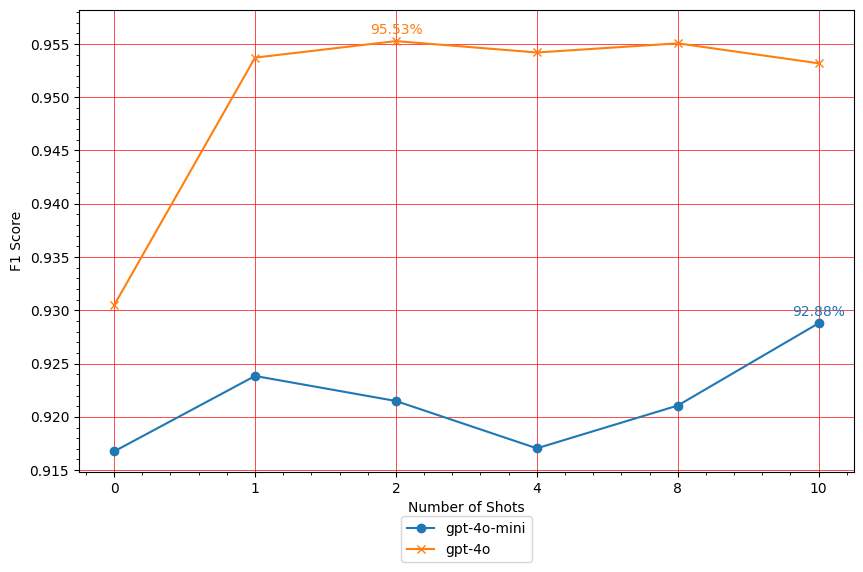

In [36]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["f1"],
    ["F1 Score"],
    ylimits_offset=0.001,
    bbox_to_anchor=(0.5, -0.21),
)

In [55]:
def majority_vote(v1, v2, v3):
    v1_ans, v2_ans, v3_ans = extract_answer(v1), extract_answer(v2), extract_answer(v3)
    v = v1
    if v2_ans == v3_ans and v3_ans != v1_ans:
        v = v2

    return v.replace("```json", "").replace("```", "").strip()

In [56]:
columns = ["gpt-4o/shots-02(1.183)", "gpt-4o/shots-08(1.244)", "gpt-4o/shots-04(1.242)"]
df_results["gpt-4o_label"] = df_results.apply(
    lambda x: majority_vote(x[columns[0]], x[columns[1]], x[columns[2]]), axis=1
)

df_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147 entries, 0 to 1146
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Headline_Details             1146 non-null   object
 1   Year                         1147 non-null   int64 
 2   Month                        1147 non-null   int64 
 3   Week                         1147 non-null   int64 
 4   Details_cleaned              1147 non-null   object
 5   Category                     1147 non-null   object
 6   Summarized_label             1147 non-null   object
 7   gpt-4o-mini/shots-00(1.024)  1147 non-null   object
 8   gpt-4o-mini/shots-01(1.035)  1147 non-null   object
 9   gpt-4o-mini/shots-02(1.061)  1147 non-null   object
 10  gpt-4o-mini/shots-04(1.117)  1147 non-null   object
 11  gpt-4o-mini/shots-08(1.278)  1147 non-null   object
 12  gpt-4o-mini/shots-10(1.230)  1147 non-null   object
 13  gpt-4o/shots-00(1.191)       1147

/var/folders/tm/rhn6g18n0l513sh2p9h57t780000gn/T/ipykernel_37822/500050548.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results["gpt-4o_label"] = df_results.apply(


In [61]:
df_results["gpt-4o_answer"] = df_results["gpt-4o_label"].apply(lambda x: extract_answer(x))

/var/folders/tm/rhn6g18n0l513sh2p9h57t780000gn/T/ipykernel_37822/1531169289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results["gpt-4o_answer"] = df_results["gpt-4o_label"].apply(lambda x: extract_answer(x))


In [62]:
delta = df_results[df_results["Summarized_label"] != df_results["gpt-4o_answer"]]
delta = delta.reset_index(drop=True)
delta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Headline_Details             50 non-null     object
 1   Year                         50 non-null     int64 
 2   Month                        50 non-null     int64 
 3   Week                         50 non-null     int64 
 4   Details_cleaned              50 non-null     object
 5   Category                     50 non-null     object
 6   Summarized_label             50 non-null     object
 7   gpt-4o-mini/shots-00(1.024)  50 non-null     object
 8   gpt-4o-mini/shots-01(1.035)  50 non-null     object
 9   gpt-4o-mini/shots-02(1.061)  50 non-null     object
 10  gpt-4o-mini/shots-04(1.117)  50 non-null     object
 11  gpt-4o-mini/shots-08(1.278)  50 non-null     object
 12  gpt-4o-mini/shots-10(1.230)  50 non-null     object
 13  gpt-4o/shots-00(1.191)       50 non-n

In [68]:
1 - len(delta) / len(df_results)

0.95640802092415

In [63]:
print_row_details(delta, indices=delta.index, columns=["Headline_Details", "Summarized_label", "gpt-4o_answer", "gpt-4o_label"])

--------------------------------------------------
Headline_Details: Christine delayed in Spain and Portugal due to foul weather Industry sources indicate on November 3 that the Christine cargo vessel was delayed in Setubal and A Coruna from October 25 to November 1 while being tugged by VB Hispania from Conakry to Bremerhaven after suffering a technical failure on October 10.
--------------------------------------------------
Summarized_label: Administrative Issue
--------------------------------------------------
gpt-4o_answer: Weather
--------------------------------------------------
gpt-4o_label: {
  "category": "Weather",
  "specific_tags": ["Weather Advisory"]
}
--------------------------------------------------
Headline_Details: UPDATE 1 - Close US election likely to lead to increased risk of violent protests, leading to property damage and altercations between protesters The United States on 3 November held elections for president, along with 35 Senate contests and all 435 Hou

In [64]:
df["gpt-4o_label"] = df_results["gpt-4o_label"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147 entries, 0 to 1146
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  1147 non-null   int64  
 1   Headline            1147 non-null   object 
 2   Details             1147 non-null   object 
 3   Severity            1147 non-null   object 
 4   Region              1147 non-null   object 
 5   Datetime            1147 non-null   object 
 6   lat                 757 non-null    float64
 7   lon                 757 non-null    float64
 8   maritime_label      1147 non-null   bool   
 9   found_ports         1147 non-null   object 
 10  contains_port_info  1147 non-null   bool   
 11  if_labeled          1146 non-null   object 
 12  Headline_Details    1146 non-null   object 
 13  Year                1147 non-null   int64  
 14  Month               1147 non-null   int64  
 15  Week                1147 non-null   int64  
 16  Detail

In [65]:
df.head()

,id,Headline,Details,Severity,Region,Datetime,lat,lon,maritime_label,found_ports,contains_port_info,if_labeled,Headline_Details,Year,Month,Week,Details_cleaned,Category,Summarized_label,gpt-4o_label
0,1432,"Courts, schools and hospitals evacuated across...",Russian media sources are reporting that court...,Moderate,Russia,2019-12-26 16:42:00,NaN,NaN,False,['st petersburg'],True,False,"Courts, schools and hospitals evacuated across...",2019,12,52,russian medium source reporting court school h...,Public Safety / Security,Terrorism,"{\n ""category"": ""Terrorism"",\n ""specific_tag..."
1,4061,Quarantine Requirements in China Reportedly Im...,"On Thursday, it was reported that the operatio...",Minor,China,2020-03-04 22:35:00,NaN,NaN,False,['shanghai'],True,True,Quarantine Requirements in China Reportedly Im...,2020,3,10,thursday reported operation u.s. air cargo com...,Regulatory Advisory,Administrative Issue,"{\n ""category"": ""Administrative Issue"",\n ""s..."
2,75,Average waiting time about 0.5 to 1 day at Por...,Local sources on December 12 report that the w...,Minor,Republic of Korea,2018-12-13 05:38:00,35.10361,129.04228,True,['busan'],True,True,Average waiting time about 0.5 to 1 day at Por...,2018,12,50,local source december 12 report waiting time v...,Port Congestion,Administrative Issue,"{\n ""category"": ""Administrative Issue"",\n ""s..."
3,3543,Freight train derailment at Oak Point Rail Yar...,"On September 8, media sources reported that a ...",Moderate,United States,2020-09-09 16:32:00,40.81225,-73.89687,False,['new york'],True,True,Freight train derailment at Oak Point Rail Yar...,2020,9,37,september 8 medium source reported csx freight...,Train Accident / Derailment,Accident,"{\n ""category"": ""Accident"",\n ""specific_tags..."
4,3922,Port Captaincy of Cartagena Dimar declared for...,Port Captaincy of Cartagena Dimar declared for...,Minor,Colombia,2020-04-09 12:22:00,NaN,NaN,False,['cartagena'],True,False,Port Captaincy of Cartagena Dimar declared for...,2020,4,15,port captaincy cartagena dimar declared second...,"Miscellaneous Events, Political Info / Event",Administrative Issue,"{\n ""category"": ""Administrative Issue"",\n ""s..."


In [66]:
df.to_csv(test_data_path, index=False)

## System Info

In [18]:
!pip install -q psutil

In [19]:
import psutil

# Get the system memory information
memory_info = psutil.virtual_memory()

# Print the total, available, and used memory
print(f"Total memory: {memory_info.total / (1024 ** 3):.2f} GB")
print(f"Available memory: {memory_info.available / (1024 ** 3):.2f} GB")
print(f"Used memory: {memory_info.used / (1024 ** 3):.2f} GB")
print(f"Memory percentage: {memory_info.percent}%")

Total memory: 64.00 GB
Available memory: 21.11 GB
Used memory: 39.31 GB
Memory percentage: 67.0%


In [20]:
import platform


def get_os_info():
    os_info = {
        "System": platform.system(),
        "Node Name": platform.node(),
        "Release": platform.release(),
        "Version": platform.version(),
        "Machine": platform.machine(),
        "Processor": platform.processor(),
    }
    return os_info


os_info = get_os_info()
for key, value in os_info.items():
    print(f"{key}: {value}")

System: Darwin
Node Name: K52V27K2X2
Release: 23.6.0
Version: Darwin Kernel Version 23.6.0: Thu Sep 12 23:36:23 PDT 2024; root:xnu-10063.141.1.701.1~1/RELEASE_ARM64_T6031
Machine: arm64
Processor: arm


In [21]:
# printe current date & time
from datetime import datetime

now = datetime.now()
print("Current date/time:", now)

Current date/time: 2024-12-13 20:07:01.337287
